In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [27]:
def eval_model(dt_classifier,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_predict = dt_classifier.predict(X_train)
    print("Train Accuracy :", accuracy_score(y_train,y_predict))
    print("Train Confusion Matrix :")
    print(confusion_matrix(y_train, y_predict))
    print("Train Recall :")
    print(recall_score(y_train, y_predict))
    print("-"*50)
    #result on test:
    y_predict = dt_classifier.predict(X_test)
    print("Test Accuracy :", accuracy_score(y_test, y_predict))
    print("Test Confusion Matrix :")
    print(confusion_matrix(y_test, y_predict))
    print("Test Recall :")
    print(recall_score(y_test, y_predict))

In [48]:
getdata().shape

===With Free Games===
rows filtered:  -234
Total Rows :  26841
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
Number of outliers removed: 1820
Data shape after removing outliers: (25021, 18)


(25021, 18)

(27075, 18)
===With Free Games===
rows filtered:  -234
Total Rows :  26841
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']


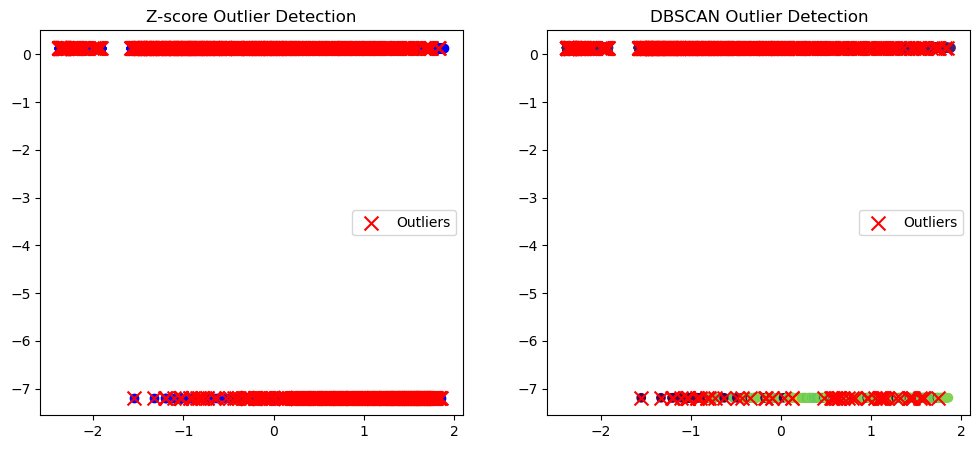

Number of outliers removed: 1637
Data shape after removing outliers: (25204, 18)


,count,mean,std,min,25%,50%,75%,max
appid,25204.0,598050.500040,248600.787209,280.0,404990.00,600705.00,798567.50,1069460.00
english,25204.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
required_age,25204.0,0.004087,0.152819,0.0,0.00,0.00,0.00,7.00
achievements,25204.0,0.563403,0.495974,0.0,0.00,1.00,1.00,1.00
positive_ratings,25204.0,407.638668,2120.087602,0.0,6.00,23.00,108.00,53710.00
negative_ratings,25204.0,87.906205,397.109151,0.0,2.00,8.00,37.00,11583.00
average_playtime,25204.0,68.265236,270.250223,0.0,0.00,0.00,0.00,5647.00
median_playtime,25204.0,70.484050,285.793190,0.0,0.00,0.00,0.00,7099.00
owners,25204.0,80027.773369,296735.507307,10000.0,10000.00,10000.00,35000.00,3500000.00
price,25204.0,5.320542,4.856519,0.0,1.69,3.99,7.19,24.99


In [52]:
def getdata(remove_free = False):
    data = pd.read_csv('Steam/steam.csv')
    print(data.shape)
    data['owners'] = data['owners'].str.split('-', expand=True).astype(int).mean(axis=1)
    row_1,col_1 = data.shape
    data['achievements'] = data['achievements'].apply(lambda x: 1 if x > 0 else 0)

    # remove genres
    str_to_remove = ['Photo Editing', 'Audio Production', 'Accounting', 'Software Training', 'Web Publishing', 'Utilities', 'Documentary', 'Education', 'Game Development', 'Design & Illustration', 'Tutorial', 'Video Production', 'Animation & Modeling']
    data = data[~data['genres'].str.contains('|'.join(str_to_remove))]
    
    if remove_free == True:
        data = data[data['price'] != 0]
        print('===Free Games Removed===')
    else:
        print('===With Free Games===')
    # remove top 6 due to anomalies
    top6_price = data['price'].nlargest(6)
    data = data[~data['price'].isin(top6_price)]

    data.reset_index(drop=True, inplace=True)
    row_2,col_2 = data.shape
    print("rows filtered: ", row_2-row_1)
    print("Total Rows : ", row_2)
    print(list(data.keys()))
    
    # Select numeric columns
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    # Standardize features for better performance
    X = StandardScaler().fit_transform(data[numeric_columns])

    # Calculate Z-score
    z_scores = np.abs(stats.zscore(X))

    # Define a threshold for outliers (e.g., data points with Z-score > 3)
    z_threshold = 3
    outliers_z = np.where(np.any(z_scores > z_threshold, axis=1))

    # Perform DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X)

    # Identify outliers (noise points) in DBSCAN
    outliers_dbscan = np.where(dbscan.labels_ == -1)
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.scatter(X[:, 0], X[:, 1], c='blue')
    ax1.scatter(X[outliers_z, 0], X[outliers_z, 1], c='red', marker='x', s=100, label='Outliers')
    ax1.set_title('Z-score Outlier Detection')
    ax1.legend()

    ax2.scatter(X[:, 0], X[:, 1], c=dbscan.labels_, cmap='viridis')
    ax2.scatter(X[outliers_dbscan, 0], X[outliers_dbscan, 1], c='red', marker='x', s=100, label='Outliers')
    ax2.set_title('DBSCAN Outlier Detection')
    ax2.legend()

    plt.show()
    # Remove outliers detected by Z-score
    data_filtered = data.drop(outliers_z[0])
    print("Number of outliers removed:", len(outliers_z[0]))
    print("Data shape after removing outliers:", data_filtered.shape)
    
    return data_filtered

getdata().describe().T

(27075, 18)
===With Free Games===
rows filtered:  -234
Total Rows :  26841
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']


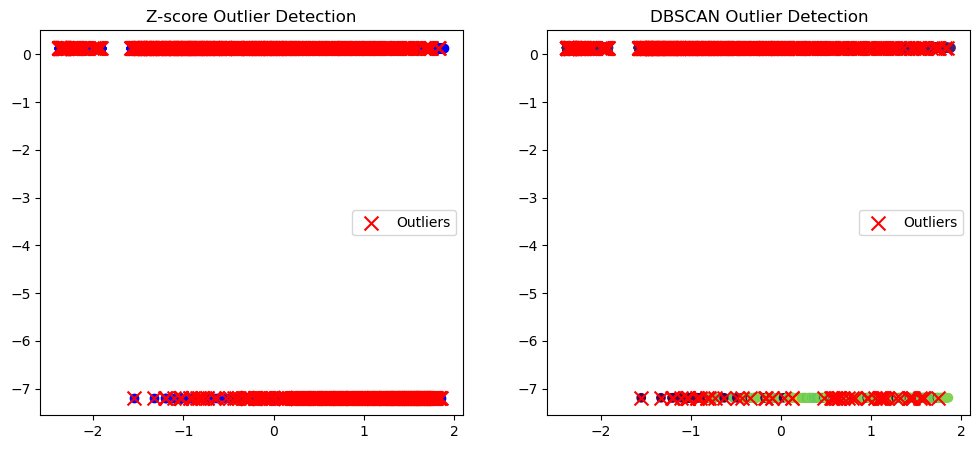

Number of outliers removed: 1637
Data shape after removing outliers: (25204, 18)
(25204, 389)
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price', 'release_year', 'platforms_linux', 'platforms_mac', 'platforms_windows', 'categories_Captions available', 'categories_Co-op', 'categories_Commentary available', 'categories_Cross-Platform Multiplayer', 'categories_Full controller support', 'categories_In-App Purchases', 'categories_Includes Source SDK', 'categories_Includes level editor', 'categories_Local Co-op', 'categories_Local Multi-Player', 'categories_MMO', 'categories_Mods', 'categories_Mods (require HL2)', 'categories_Multi-player', 'categories_Online Co-op', 'categories_Online Multi-Player', 'categories_Partial Controller Support', 'categories_Shared/Split Screen', 'categories_Single-player', 'categories_Stats', 'categories_Steam Achievements', '

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

# Load the dataset
data = getdata()

# Convert release_date to datetime and extract the year
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data['release_date'].dt.year

# MultiLabelBinarizer for multiple value columns
multi_label_binarizer = MultiLabelBinarizer()
multi_val_columns = ['platforms', 'categories', 'genres', 'steamspy_tags']

for col in multi_val_columns:
    data[col] = data[col].apply(lambda x: x.split(';'))
    one_hot_encoded = multi_label_binarizer.fit_transform(data[col])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[f"{col}_{category}" for category in multi_label_binarizer.classes_])
    data = pd.concat([data.reset_index(drop=True), one_hot_encoded_df.reset_index(drop=True)], axis=1)

# Drop the original columns that have been one-hot encoded
data.drop(['platforms', 'categories', 'genres', 'steamspy_tags'], axis=1, inplace=True)

# Calculate the midpoint of the owners' range
data['owners_midpoint_log'] = np.log1p(data['owners'])

# Drop the original owners column
data.drop(['owners'], axis=1, inplace=True)

# Standardize numerical features
num_features = ['positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

print(data.shape)
# Split the dataset into training and testing sets
X = data.drop(['appid',
               'positive_ratings',
               'negative_ratings',
               'average_playtime',
               'median_playtime',
               'name',
               'release_date',
               'release_year',
               'developer',
               'publisher',
               'owners_midpoint_log',
               'achievements',
               'price'
              ], axis=1)
y = data['owners_midpoint_log']
print(list(data.keys()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [62]:
encoded_data['owners_midpoint_log'].describe()

count    25204.000000
mean         9.913209
std          1.242109
min          9.210440
25%          9.210440
50%          9.210440
75%         10.463132
max         15.068274
Name: owners_midpoint_log, dtype: float64

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# X_train = train_data.drop(['owners_midpoint_log'], axis=1)
# y_train = train_data['owners_midpoint_log']
# X_test = test_data.drop(['owners_midpoint_log'], axis=1)
# y_test = test_data['owners_midpoint_log']

# Create and train the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Calculate and print R2 scores and MSE
print("Linear Regression - Training R2 Score:", r2_score(y_train, y_train_pred))
print("Linear Regression - Test R2 Score:", r2_score(y_test, y_test_pred))
print("Linear Regression - Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Linear Regression - Test MSE:", mean_squared_error(y_test, y_test_pred))


Linear Regression - Training R2 Score: 0.4652914859287691
Linear Regression - Test R2 Score: -59869847610105.805
Linear Regression - Training MSE: 0.8287520785823891
Linear Regression - Test MSE: 91366007537026.28


In [64]:
# Convert 'owners_midpoint_log' to a binary classification problem (e.g., high or low sales)
y_train_class = (y_train > y_train.median()).astype(int)
y_test_class = (y_test > y_test.median()).astype(int)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score

# Create and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_class)

# Make predictions
y_train_pred_class = log_reg.predict(X_train)
y_test_pred_class = log_reg.predict(X_test)

# Calculate and print accuracy and recall scores
print("Logistic Regression - Training Accuracy:", accuracy_score(y_train_class, y_train_pred_class))
print("Logistic Regression - Test Accuracy:", accuracy_score(y_test_class, y_test_pred_class))
print("Logistic Regression - Training Recall:", recall_score(y_train_class, y_train_pred_class))
print("Logistic Regression - Test Recall:", recall_score(y_test_class, y_test_pred_class))
print("Logistic Regression - Training MSE:", mean_squared_error(y_train_class, y_train_pred_class))
print("Logistic Regression - Test MSE:", mean_squared_error(y_test_class, y_test_pred_class))


Logistic Regression - Training Accuracy: 0.8064278426482259
Logistic Regression - Test Accuracy: 0.7878868024332187
Logistic Regression - Training Recall: 0.5705067375213513
Logistic Regression - Test Recall: 0.5318595578673602
Logistic Regression - Training MSE: 0.1935721573517742
Logistic Regression - Test MSE: 0.21211319756678126


In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Define your target variable
y = encoded_data['owners_midpoint_log']

# Define your feature variables
X = encoded_data.drop(['appid',
                       'positive_ratings',
                       'negative_ratings',
                       'average_playtime',
                       'median_playtime',
                       'name',
                       'release_date',
                       'release_year',
                       'developer',
                       'publisher',
                       'owners_midpoint_log',
                       'achievements',
                       'price'
                      ], axis=1)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Find the optimal number of clusters using silhouette score
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(f"K-Means - Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

# Use the optimal number of clusters and apply K-Means
optimal_clusters = 4  # Assume 4 is the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train)
test_cluster_labels = kmeans.predict(X_test)

# Add cluster labels to train_data and test_data
train_data['cluster'] = train_cluster_labels
test_data['cluster'] = test_cluster_labels



K-Means - Number of Clusters: 2, Silhouette Score: 0.12923510942925023
K-Means - Number of Clusters: 3, Silhouette Score: 0.15558101572590413
K-Means - Number of Clusters: 4, Silhouette Score: 0.15025464208701012
K-Means - Number of Clusters: 5, Silhouette Score: 0.13606897266234155
K-Means - Number of Clusters: 6, Silhouette Score: 0.14656027161586996
K-Means - Number of Clusters: 7, Silhouette Score: 0.154148866756371
K-Means - Number of Clusters: 8, Silhouette Score: 0.13166827697682984
K-Means - Number of Clusters: 9, Silhouette Score: 0.16056881529128322
K-Means - Number of Clusters: 10, Silhouette Score: 0.182028817610151


AttributeError: 'NoneType' object has no attribute 'split'

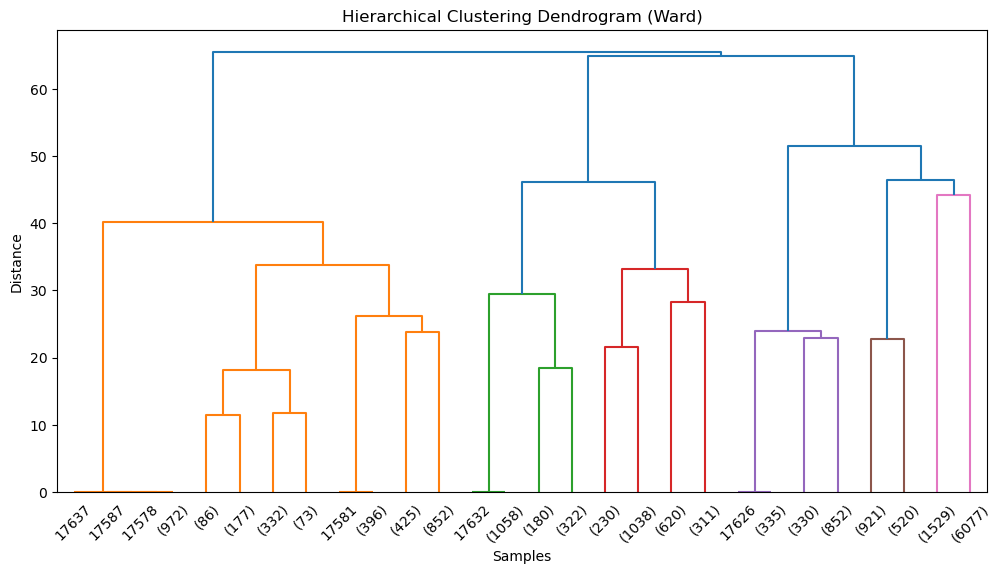

In [66]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the 'ward' method
Z = linkage(X_train, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=4)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.show()


In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the decision tree model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Create and train the random forest model
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

# Make predictions
y_train_tree_pred = tree_reg.predict(X_train)
y_test_tree_pred = tree_reg.predict(X_test)
y_train_forest_pred = forest_reg.predict(X_train)
y_test_forest_pred = forest_reg.predict(X_test)

# Calculate and print R2 scores and MSE
print("Decision Tree - Training R2 Score:", r2_score(y_train, y_train_tree_pred))
print("Decision Tree - Test R2 Score:", r2_score(y_test, y_test_tree_pred))
print("Decision Tree - Training MSE:", mean_squared_error(y_train, y_train_tree_pred))
print("Decision Tree - Test MSE:", mean_squared_error(y_test, y_test_tree_pred))

print("Random Forest - Training R2 Score:", r2_score(y_train, y_train_forest_pred))
print("Random Forest - Test R2 Score:", r2_score(y_test, y_test_forest_pred))
print("Random Forest - Training MSE:", mean_squared_error(y_train, y_train_forest_pred))
print("Random Forest - Test MSE:", mean_squared_error(y_test, y_test_forest_pred))


Decision Tree - Training R2 Score: 0.5679840200568088
Decision Tree - Test R2 Score: 0.20046010817226068
Decision Tree - Training MSE: 0.6695875078417625
Decision Tree - Test MSE: 1.2201595744592224
Random Forest - Training R2 Score: 0.5422744953426785
Random Forest - Test R2 Score: 0.29323905847467735
Random Forest - Training MSE: 0.7094350537204923
Random Forest - Test MSE: 1.0785717366579284


In [68]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the k-Nearest Neighbors model
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

# Make predictions
y_train_knn_pred = knn_reg.predict(X_train)
y_test_knn_pred = knn_reg.predict(X_test)

# Calculate and print R2 scores and MSE
print("k-Nearest Neighbors - Training R2 Score:", r2_score(y_train, y_train_knn_pred))
print("k-Nearest Neighbors - Test R2 Score:", r2_score(y_test, y_test_knn_pred))
print("k-Nearest Neighbors - Training MSE:", mean_squared_error(y_train, y_train_knn_pred))
print("k-Nearest Neighbors - Test MSE:", mean_squared_error(y_test, y_test_knn_pred))


k-Nearest Neighbors - Training R2 Score: 0.3155561568806008
k-Nearest Neighbors - Test R2 Score: 0.16160075147274489
k-Nearest Neighbors - Training MSE: 1.0608289240417013
k-Nearest Neighbors - Test MSE: 1.2794619515124186


In [69]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Fit the regressor to the training data
xgb_reg.fit(X_train, y_train)

# Make predictions on training data
train_preds = xgb_reg.predict(X_train)

# Calculate metrics for the training data
train_r2 = r2_score(y_train, train_preds)
train_mse = mean_squared_error(y_train, train_preds)

# Make predictions on test data
test_preds = xgb_reg.predict(X_test)

# Calculate metrics for the test data
test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

# Print the results
print(f"Training Metrics:\nR2 Score: {train_r2}\nMean Squared Error: {train_mse}")
print(f"\nTest Metrics:\nR2 Score: {test_r2}\nMean Squared Error: {test_mse}")


Training Metrics:
R2 Score: 0.4448502809917755
Mean Squared Error: 0.8604341831953809

Test Metrics:
R2 Score: 0.32616120824450745
Mean Squared Error: 1.0283299955465377


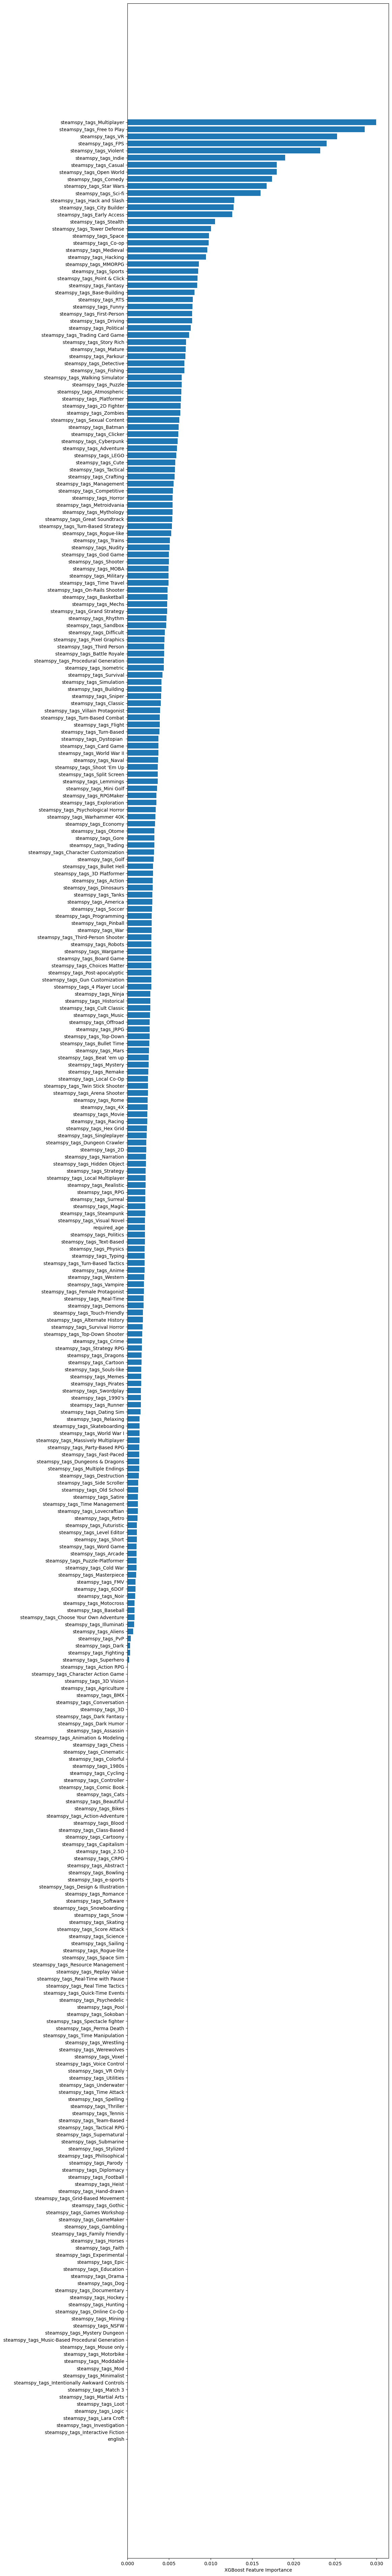

In [70]:
import matplotlib.pyplot as plt

# Get feature importances
importances = xgb_reg.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, len(sorted_idx) * 0.3))
plt.barh(range(X_train.shape[1]), importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel('XGBoost Feature Importance')
plt.show()


In [71]:
print(feature_names)

Index(['english', 'required_age', 'steamspy_tags_1980s',
       'steamspy_tags_1990's', 'steamspy_tags_2.5D', 'steamspy_tags_2D',
       'steamspy_tags_2D Fighter', 'steamspy_tags_3D',
       'steamspy_tags_3D Platformer', 'steamspy_tags_3D Vision',
       ...
       'steamspy_tags_Wargame', 'steamspy_tags_Warhammer 40K',
       'steamspy_tags_Werewolves', 'steamspy_tags_Western',
       'steamspy_tags_Word Game', 'steamspy_tags_World War I',
       'steamspy_tags_World War II', 'steamspy_tags_Wrestling',
       'steamspy_tags_Zombies', 'steamspy_tags_e-sports'],
      dtype='object', length=328)


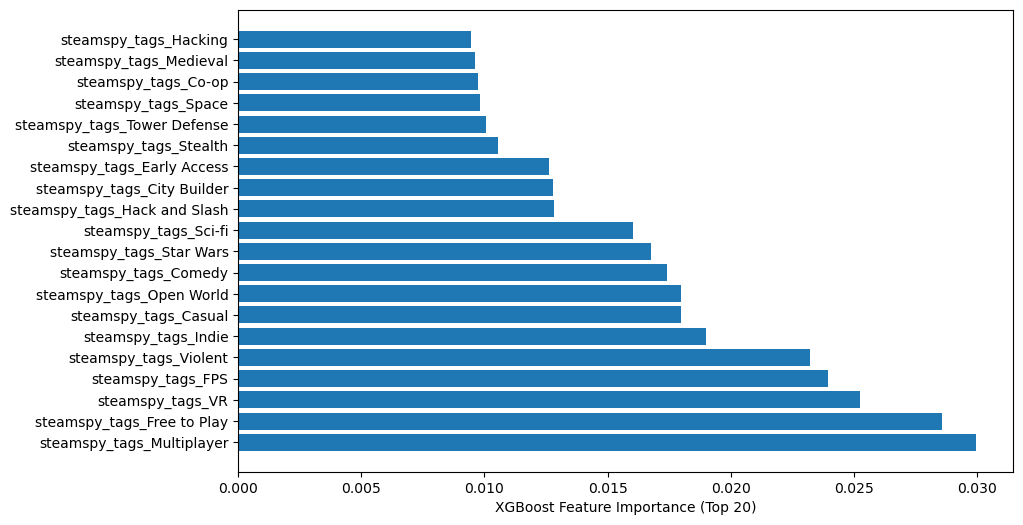

In [73]:
import matplotlib.pyplot as plt

# Get feature importances
importances = xgb_reg.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]

# Select top 20 features
top_20_features = sorted_idx[:20]

# Plot feature importances for top 20 features
plt.figure(figsize=(10, len(top_20_features) * 0.3))
plt.barh(range(len(top_20_features)), importances[top_20_features])
plt.yticks(range(len(top_20_features)), [feature_names[i] for i in top_20_features])
plt.xlabel('XGBoost Feature Importance (Top 20)')
plt.show()
